In [1]:
import logging
import comet_ml
import helper_functions as hf
from pyspark.sql import functions as F

from pyspark.sql import SparkSession, DataFrame
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler, MinMaxScaler
from pyspark.sql.functions import col, corr, count, when
from pyspark.sql.types import IntegerType


from pyspark.ml.evaluation import (
    MulticlassClassificationEvaluator,
    BinaryClassificationEvaluator,
)
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.feature import VectorAssembler, MinMaxScaler

from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression,GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import PipelineModel, Pipeline

from datetime import datetime


# Sparkling Water
from pysparkling import H2OContext
from pyspark.sql import SparkSession
from pysparkling.ml import H2OGLM

## Build Spark Session

In [2]:
def create_spark_session(
    app_name="Sparkify",
    default_settings=True,
    total_physical_cores=16,
    driver_memory=8,
    executor_memory=8,
    quiet=True,
):
    try:
        spark.shutdown()
    except Exception as e:
        print(e)

    if default_settings == False:
        total_physical_cores = input(" Available Cores")
        driver_memory = input(" Driver Memory Allowance")
        executor_memory = input("Executor Memory Allowance")

    available_cores_for_spark = int(total_physical_cores - 2)
    # Configure Spark session
    spark = (
        SparkSession.builder.appName(app_name)
        # .config("spark.driver.memory", str(int(driver_memory)) + "g")
        # .config("spark.executor.memory", str(int(executor_memory)) + "g")
        .config("spark.memory.fraction", "0.8")
        .config("spark.executor.cores", available_cores_for_spark)
        .getOrCreate()
    )

    def quiet_logs(sc):
        logger = sc._jvm.org.apache.log4j
        logger.LogManager.getLogger("org").setLevel(logger.Level.ERROR)
        logger.LogManager.getLogger("akka").setLevel(logger.Level.ERROR)
        logger.LogManager.getLogger("agerMaster").setLevel(logger.Level.ERROR)
        logger.LogManager.getLogger("Thread-2").setLevel(logger.Level.ERROR)

    if quiet == True:
        quiet_logs(spark.sparkContext)

    return spark


spark = create_spark_session(quiet=True)

local variable 'spark' referenced before assignment


24/01/30 20:32:00 WARN Utils: Your hostname, Jacobs-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.4.156 instead (on interface en0)
24/01/30 20:32:00 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
24/01/30 20:32:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/30 20:32:00 WARN SparkContext: The JAR file:///Users/jacobfletcher/anaconda3/envs/sparkify_churn/lib/python3.10/site-packages/sparkling_water/sparkling_water_assembly.jar at spark://192.168.4.156:54739/jars/sparkling_water_assembly.jar has been added already. Overwriting of added jar is not supported in the current version.


# Pyspark Model Class

In [64]:
from datetime import datetime
import logging
import matplotlib.pyplot as plt
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import seaborn as sns


from sklearn.metrics import (
    precision_score,
    recall_score,
    confusion_matrix,
    accuracy_score,
    f1_score,
    roc_auc_score,
    fbeta_score,
    ConfusionMatrixDisplay,
)

from decouple import config


class pyspark_model:
    def __init__(self, model_name, trainer_config, experiment_logging=True):
        self.init_logging()
        self.experiment_logging = experiment_logging
        if self.experiment_logging == True:
            self.initiate_comet()

        # Start Model Config
        self.model_name = model_name
        self.config = trainer_config[model_name]
        self.model = self.config["model"]

        self.nFolds = self.config["nFolds"]
        self.evaluator = self.config["evaluator"]

        # Build Pipline
        self.stages = self.config["stages"]
        self.pipeline = Pipeline(stages=[self.model] + self.stages)
        self.app.info(self.pipeline.getStages())

        # Build Grid
        self.model_params = self.config["param_grid"]
        self.param_grid = self.build_param_grid()
        self.crossval = None

        # Scaler
        self.scaler = None

    def build_param_grid(self):
        param_grid_builder = ParamGridBuilder()
        for param, values in self.model_params.items():
            param_grid_builder = param_grid_builder.addGrid(
                getattr(self.model, param), values
            )
        return param_grid_builder.build()

    def get_log_time(self):
        return datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    def init_logging(self):
        logging.basicConfig(
            level=logging.INFO,
            format="%(asctime)s - %(name)s - %(levelname)s - %(message)s",
        )
        self.app = logging.getLogger("SPARKIFY")
        self.app.info("Logging initialized %s.", self.get_log_time())

    def initiate_comet(self):
        self.experiment = comet_ml.Experiment(
            api_key=config("COMET_API"),
            project_name=config("PROJECT_NAME"),
            workspace=config("WORKSPACE"),
        )
        return self

    def calculate_specificity(self):
        tn, fp, fn, tp = confusion_matrix(self.y_test, self.y_pred).ravel()
        return tn / (tn + fp)

    def calculate_f1(self):
        return f1_score(y_pred=self.y_pred, y_true=self.y_test)

    def calculate_precision(self):
        return precision_score(y_pred=self.y_pred, y_true=self.y_test)

    def calculate_recall(self):
        return recall_score(y_pred=self.y_pred, y_true=self.y_test)

    def calculate_accuracy(self):
        return accuracy_score(y_pred=self.y_pred, y_true=self.y_test)

    def calculate_f2(self):
        return fbeta_score(y_pred=self.y_pred, y_true=self.y_test, beta=2)

    def calculate_auc(self):
        return roc_auc_score(y_score=self.y_pred, y_true=self.y_test)

    def calculate_metrics(self):
        self.metrics = {
            "AUC": self.calculate_auc(),
            "f1": self.calculate_f1(),
            "recall": self.calculate_recall(),
            "precision": self.calculate_precision(),
            "accuracy": self.calculate_accuracy(),
            "f2": self.calculate_f2(),
            "specificity": self.calculate_specificity(),
        }

        if self.experiment_logging == True:
            self.comet_logger()
            self.experiment.end()
        return self.metrics

    def conf_matrix_display(self):
        cm = confusion_matrix(y_true=self.y_test, y_pred=self.y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)

        # Create a new figure for each plot
        fig, ax = plt.subplots()
        disp.plot(ax=ax)

        # Set the title for the entire figure
        fig.suptitle(f"Confusion Matrix - {self.model_name}", fontsize=16)

        # Show the figure
        plt.show()

    def comet_logger(self):
        self.experiment.log_metrics(self.metrics)
        self.build_params()
        self.experiment.log_parameters(self.model_parameters)
        self.experiment.log_confusion_matrix(
            y_true=self.y_test,
            y_predicted=self.y_pred,
            step=0,
            title="Confusion Matrix",
            file_name="confusion-matrix-%03d.json" % 0,
        )

    def build_params(self):
        self.model_parameters = {
            "model_name": self.model_name,
            "model_params": self.model_params,
            "model": self.model_name,
            "best_model_param": self.best_model.stages[-1].extractParamMap().items(),
            "evaluator": self.evaluator,
            "cross_valid": self.crossval,
            "nFfolds": self.nFolds,
            
        }

     
    
    def build_model(self):
        self.crossval = CrossValidator(
            estimator=self.pipeline,
            estimatorParamMaps=self.param_grid,
            evaluator=self.evaluator,
            numFolds=self.nFolds,
        )
        

    def scale_and_split(self, df, input_cols=None):
        if input_cols is None:
            input_cols = [
                col_name
                for col_name, data_type in df.dtypes
                if data_type in ["double", "int"]
            ]


        self.feature_cols = [ col for col in input_cols if col in df.columns]
        for col in input_cols:
            if col not in df.columns:
                self.app.warn(f"Column {col} is not in the submitted dataframe and cannot be used")


        assembler = VectorAssembler(inputCols=self.feature_cols, outputCol="features")

        assembled_data = assembler.transform(df)

        

        if assembled_data.first()["features"].size == 0:
            raise ValueError("Vector dimension is zero. Please check your input data.")

        test_data, train_data = assembled_data.randomSplit(
            [0.2, 0.8], seed=42
        )

        self.scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
        self.scaler_model = self.scaler.fit(train_data)
        train_data_scaled = self.scaler_model.transform(train_data)
        test_data_scaled = self.scaler_model.transform(test_data)

        return train_data_scaled,test_data_scaled

    def fit_model(self, train_data):
        if self.crossval == None:
            self.build_model()
        self.trained_crossval = self.crossval.fit(train_data)
        self.best_model = self.trained_crossval.bestModel

    def predict_model(self, test_data):
        predictions = self.best_model.transform(test_data)
        labels_list = predictions.select("label").collect()
        predictions_list = predictions.select("prediction").collect()
        self.y_test = [int(row["label"]) for row in labels_list]
        self.y_pred = [int(row["prediction"]) for row in predictions_list]

In [65]:
from pyspark.ml.linalg import DenseVector, SparseVector



# Assuming 'df' is your PySpark DataFrame
def check_vector(df):
    sparse_v = []
    dense_v = []
    dense_v_count = 0
    sparse_v_count = 0


    for i in range(df.shape[0]):
        vector = df.iloc[i][0]
        if isinstance(vector, DenseVector):
            dense_v.append(i)
            dense_v_count += 1
        
        elif isinstance(vector, SparseVector):
            sparse_v.append(i)
            sparse_v_count += 1           
    print("Sparse Vector:", sparse_v_count)
    print("Dense Vector:", dense_v_count)

    return dense_v, sparse_v

def index_select(df, indices):
    from pyspark.sql.functions import monotonically_increasing_id 

    df_with_index = df.withColumn("index",monotonically_increasing_id())

# Select rows based on the indices in the list
    selected_rows = df_with_index.filter(col("index").isin(indices))

    # Drop the additional 'index' column if needed
    selected_rows = selected_rows.drop("index")

    return selected_rows


# Define Training Plan Config

In [74]:
from pyspark.ml.classification import (
    RandomForestClassifier,
    GBTClassifier,
    LogisticRegression,
)


def generate_config():
    trainer_config = {
        "logistic_regression": {
            "model": LogisticRegression(
                labelCol="label",
                featuresCol="scaled_features",
                family="binomial",
                standardization=True,
            ),
            "evaluator": MulticlassClassificationEvaluator(labelCol="label"),
            "stages": [],
            "param_grid": {
                "maxIter": [20, 40, 60],
                "regParam": [0.0, 0.1, 0.01, 0.001],
            },
            "nFolds": 4,
        },
        "random_forest": {
            "model": RandomForestClassifier(
                labelCol="label", featuresCol="scaled_features", seed=42
            ),
            "evaluator": MulticlassClassificationEvaluator(labelCol="label"),
            "stages": [],
            "param_grid": {
                # Defined as the "models attribute" : list of parameters
                "numTrees": [10, 20, 30],
                "maxDepth": [10, 20, 30],
                "minInstancesPerNode": [1, 5],
                "featureSubsetStrategy": ["auto", "sqrt"],
                "impurity": ["gini", "entropy"],
            },
            "nFolds": 4,
        },
        "gradient_boost": {
            "model": GBTClassifier(
                labelCol="label", featuresCol="scaled_features", seed=42
            ),
            "evaluator": MulticlassClassificationEvaluator(labelCol="label"),
            "stages": [],
            "param_grid": {"maxIter": [10, 20], "maxDepth": [10, 20]},
            "nFolds": 3,
        },
        #     "features":[ 'count',
        #                 'avg_daily_listens',
        #                 'level_flag',
        #    'pos_interactions',
        #    'neg_interactions',
        #    'distinct_artist',
        #    'About',
        #    'Add Friend',
        #    'Add to Playlist',
        #    'Downgrade',
        #    'Error', 'Help',
        #    'Home',
        #    'Login',
        #    'Logout',
        #    'Register',
        #      'Roll Advert',
        #        'Save Settings',
        #    'Settings',
        #    'Submit Downgrade',
        #    'Submit Registration',
        #    'Submit Upgrade',
        #    'Thumbs Down',
        #    'Thumbs Up', 'Upgrade',
        # #    'avg_time_between_sessions',
        # #    'time_since_registration',
        # #    'unique_sessions',
        #     'device_iOS',
        #    'device_Linux',
        #    'device_Other',
        #    'device_Ubuntu',
        #    'device_Mac OS X',
        #    'device_Windows',
        #      'browser_Firefox',
        #        'browser_Safari',
        #          'browser_Other',
        #    'browser_Chromium',
        #    'browser_Google',
        #    'browser_Mobile Safari',
        #    'browser_IE',
        #      'browser_Chrome']
        "features": [
            "avg_daily_listens",
            # "count",
            "song_counts",
            "level_flag",
            "pos_interactions",
            "neg_interactions",
            "distinct_artist",
            "About",
            "Add Friend",
            "Add to Playlist",
            "Downgrade",
            "Error",
            "Help",
            "Home",
            "Login",
            "Logout",
            "Register",
            "Roll Advert",
            "Save Settings",
            "Settings",
            "Submit Downgrade",
            "Submit Registration",
            "Submit Upgrade",
            "Thumbs Down",
            "Thumbs Up",
            "Upgrade",
            # "time_since_registration",
            "device_iOS",
            "device_Linux",
            "device_Other",
            "device_Ubuntu",
            "device_Mac OS X",
            "device_Windows",
            "browser_Firefox",
            "browser_Safari",
            "browser_Other",
            "browser_Chromium",
            "browser_Google",
            "browser_Mobile Safari",
            "browser_IE",
            "browser_Chrome",
            "days_since_registration"
        ],
    }


    return trainer_config

#

# Setup and Data Loading

In [93]:

file_path = "../data/lg_log4_all_features.csv"
trainer_config = generate_config()
spark = hf.create_spark_session()
df = hf.load_dataframe(file_path=file_path,spark=spark,label="label")
feature_cols = trainer_config["features"]



No Spark Sessions Active


# Model Runs

##  Logistic Regression Classifier

In [94]:
logR_model = pyspark_model("logistic_regression",trainer_config ,experiment_logging=True)

train_data,test_data = logR_model.scale_and_split(df,feature_cols)


2024-01-30 23:45:07,966 - SPARKIFY - INFO - Logging initialized 2024-01-30 23:45:07.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/dataspelunker/sparkify/93d7ee763b50468395548e1269615aba
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     git metadata                 : 1
COMET INFO:     git-patch (uncompressed)     : 1 (3.50 MB)
COMET INFO:     installed packages           : 1
COMET INFO:     notebook                     : 1
COMET INFO:     sourc

In [95]:

logR_model.fit_model(train_data)
logR_model.predict_model(test_data)

24/01/30 23:45:38 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: , userId, label, song_counts, avg_daily_listens, level_flag, pos_interactions, neg_interactions, About, Add Friend, Add to Playlist, Downgrade, Error, Help, Home, Login, Logout, Register, Roll Advert, Save Settings, Settings, Submit Downgrade, Submit Registration, Submit Upgrade, Thumbs Down, Thumbs Up, Upgrade, device_iOS, device_Linux, device_Other, device_Ubuntu, device_Mac OS X, device_Windows, browser_Firefox, browser_Safari, browser_Other, browser_Chromium, browser_Google, browser_Mobile Safari, browser_IE, browser_Chrome, distinct_artist, days_since_registration, unique_sessions
 Schema: _c0, userId, label, song_counts, avg_daily_listens, level_flag, pos_interactions, neg_interactions, About, Add Friend, Add to Playlist, Downgrade, Error, Help, Home, Login, Logout, Register, Roll Advert, Save Settings, Settings, Submit Downgrade, Submit Registration, Submit Upgrade, Thumbs Down, Thumbs U

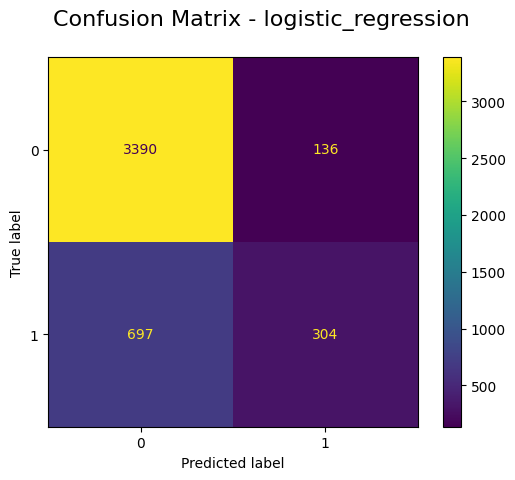

In [96]:
logR_model.conf_matrix_display()

In [ ]:
metrics = logR_model.calculate_metrics()

print("Scores:\n")
for key, value in metrics.items():
    print(f'{key}: {round(value,4)}')

print("\n \nParameters:\n")
for param, value in logR_model.best_model.stages[-1].extractParamMap().items():
    print(f"{param.name}: {value}")

## Random Forrest Classifier

In [ ]:
rForrest_model = pyspark_model(trainer_config=trainer_config,model_name="random_forest")
logging.getLogger("py4j.java_gateway").setLevel(logging.ERROR)
train_data,test_data = rForrest_model.scale_and_split(df,feature_cols)
rForrest_model.fit_model(train_data)
rForrest_model.predict_model(test_data)

In [ ]:
rForrest_model.conf_matrix_display()

In [ ]:

rForrest_metrics = rForrest_model.calculate_metrics()

print("Scores\n")
for key, value in rForrest_metrics.items():
    print(f'{key}: {round(value,4)}')

print("\n\nParameters\n")
for param, value in rForrest_model .best_model.stages[-1].extractParamMap().items():
    print(f"{param.name}: {value}")

## Gradient Boost Classifier

In [ ]:
gBoost_model = pyspark_model("gradient_boost",trainer_config, experiment_logging=False)
train_data,test_data = gBoost_model.scale_and_split(df,feature_cols)
gBoost_model.fit_model(train_data)
gBoost_model.predict_model(test_data)

In [ ]:
gBoost_model.conf_matrix_display()

In [ ]:

gBoost_metrics = rForrest_model.calculate_metrics()

print("Scores\n")
for key, value in gBoost_metrics.items():
    print(f'{key}: {round(value,4)}')

print("\n\nParameters\n")
for param, value in gBoost_model.best_model.stages[-1].extractParamMap().items():
    print(f"{param.name}: {value}")

In [ ]:
gBoost_model.trained_crossval.getEstimatorParamMaps()
